In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [3]:
languages = ['ta', 'hi', 'en']

images_train = read_all("../input/level_1_train/"+LEVEL+"/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all("../input/level_1_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/level_1_test/kaggle_"+LEVEL, key_prefix='') # change the path
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



900
Reading:



300


In [4]:
list(images_test.keys())[:5]

['171', '249', '82', '163', '16']

In [5]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(900, 256) (900,)
(300, 256)


In [6]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [7]:
print(X_scaled_train.shape)

(900, 256)


In [8]:
class FFSN_Generic:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):#n_inputs----no. of featurees
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def forward_pass(self, X):
    self.A = {}
    self.H = {}
    self.H[0] = X# X----(n,256)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]#  (n,256)*(256,2)----(n,2)
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, X):
    return X*(1-X) 
    
  def grad(self, X, Y):
    self.forward_pass(X)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    self.Y=Y.reshape(-1,1)
    L = self.nh + 1
    self.dA[L] = (self.H[L] - self.Y)#(900,1)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])#(2,900)*(900,1)---(2,1)
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)#(1,1)
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)# (900,1)*(1,2)----(900,2)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))#(900,2)*(900,2)----(900,2)
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y)
      
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * self.dW[i+1] / m
        self.B[i+1] -= learning_rate * self.dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

In [9]:
print(X_scaled_train.shape, Y_train.shape)

(900, 256) (900,)


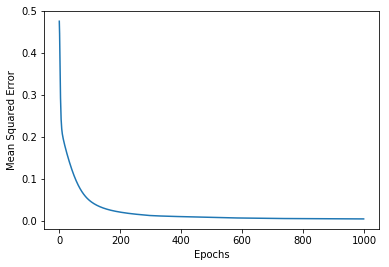

In [10]:
ff= FFSN_Generic(256,[5,5])
ff.fit(X_scaled_train, Y_train, epochs=1000,learning_rate=0.1,display_loss=True)

In [11]:
Y_pred_train=ff.predict(X_scaled_train)
Y_pred_train_binarised=(Y_pred_train>=0.5).astype('int').ravel()
Y_pred_test=ff.predict(X_scaled_test)
Y_pred_test_binarised=(Y_pred_test>=0.5).astype('int').ravel()
training_accuracy=accuracy_score(Y_train,Y_pred_train_binarised)
print(training_accuracy)

0.9944444444444445


In [12]:

# test_accuracy=accuracy_score(y_test,Y_pred_test_binarised)

## Sample Submission

In [13]:
Y_pred_test = ff.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)